In [2]:
import pandas as pd

df = pd.read_csv("/Users/kunjalbhatta/Desktop/UTEC1/default.csv")
df.head()


,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [6]:
x = df["loan"].values
y = df["default"].values

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 1_000 tune and 12_000 draw iterations (4_000 + 48_000 draws total) took 27 seconds.


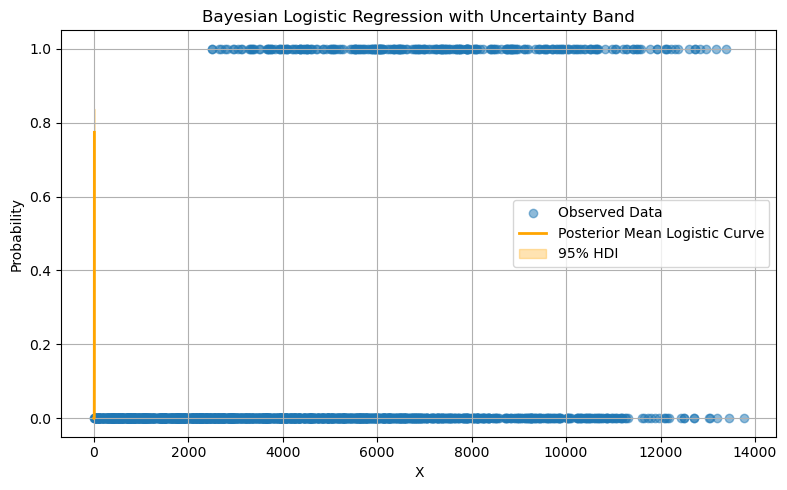

In [14]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Simulate data
np.random.seed(42)
n = 100
x = df["loan"].values
true_beta0 = -4.0
true_beta1 = 0.8
logits = true_beta0 + true_beta1 * x
p = 1 / (1 + np.exp(-logits))
y = df["default"].values

# Bayesian logistic regression model
with pm.Model() as logistic_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    
    logit_p = beta0 + beta1 * np.log(x)
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))
    
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)
    
    trace = pm.sample(12000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Extract posterior samples for prediction
x_pred = np.linspace(0, 10, 200)
beta0_samples = trace.posterior["beta0"].stack(samples=("chain", "draw")).values
beta1_samples = trace.posterior["beta1"].stack(samples=("chain", "draw")).values

# Generate predicted probabilities for each sample
probs = []
for b0, b1 in zip(beta0_samples, beta1_samples):
    prob = 1 / (1 + np.exp(-(b0 + b1 * x_pred)))
    probs.append(prob)
probs = np.array(probs)

# Compute 95% HDI interval
lower = np.percentile(probs, 2.5, axis=0)
upper = np.percentile(probs, 97.5, axis=0)
mean_pred = np.mean(probs, axis=0)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.5, label="Observed Data")
plt.plot(x_pred, mean_pred, color="orange", label="Posterior Mean Logistic Curve", linewidth=2)
plt.fill_between(x_pred, lower, upper, color="orange", alpha=0.3, label="95% HDI")
plt.xlabel("X")
plt.ylabel("Probability")
plt.title("Bayesian Logistic Regression with Uncertainty Band")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

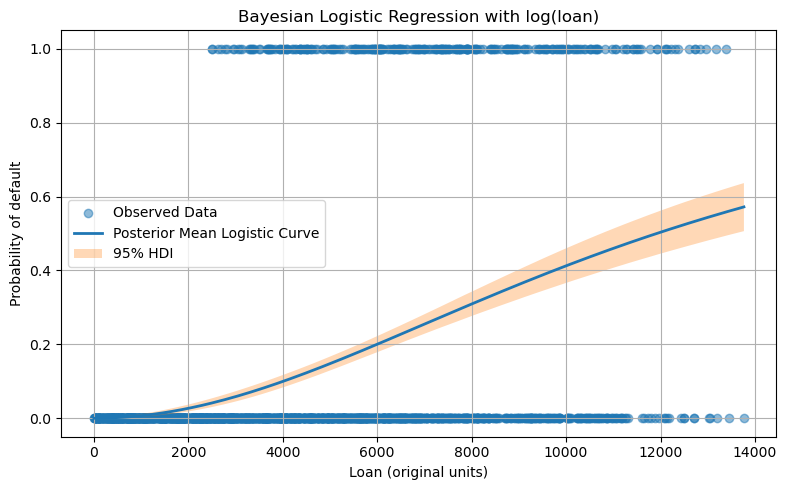

In [18]:

x_pred = np.linspace(df["loan"].min(), df["loan"].max(), 200)


beta0_samples = trace.posterior["beta0"].stack(samples=("chain", "draw")).values
beta1_samples = trace.posterior["beta1"].stack(samples=("chain", "draw")).values


log_x_pred = np.log(x_pred)  

probs = 1 / (1 + np.exp(-(beta0_samples[:, None] + beta1_samples[:, None] * log_x_pred[None, :])))



lower = np.percentile(probs, 2.5, axis=0)
upper = np.percentile(probs, 97.5, axis=0)
mean_pred = probs.mean(axis=0)


plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.5, label="Observed Data")
plt.plot(x_pred, mean_pred, linewidth=2, label="Posterior Mean Logistic Curve")
plt.fill_between(x_pred, lower, upper, alpha=0.3, label="95% HDI")
plt.xlabel("Loan (original units)")
plt.ylabel("Probability of default")
plt.title("Bayesian Logistic Regression with log(loan)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
df_filtered = df[(df["age"] > 18) & (df["age"] >= 0)].copy()

print(df_filtered["age"].describe())

count    1994.000000
mean       40.927700
std        13.271802
min        18.055189
25%        29.043284
50%        41.382673
75%        52.616900
max        63.971796
Name: age, dtype: float64


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


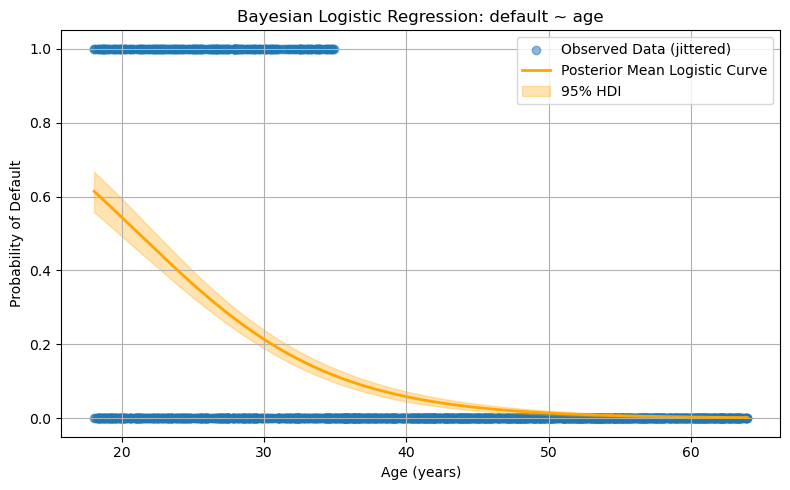

In [32]:
df_filtered = df[(df["age"] > 18) & (df["age"] >= 0)].dropna(subset=["age", "default"]).copy()
df_filtered["default"] = df_filtered["default"].astype(int)

x = df_filtered["age"].values
y = df_filtered["default"].values


x_mean, x_std = x.mean(), x.std()
x_s = (x - x_mean) / x_std

# --- Bayesian logistic regression model ---
with pm.Model() as logistic_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    
    logit_p = beta0 + beta1 * x_s
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))
    
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# --- Prediction grid in original age units ---
x_pred = np.linspace(x.min(), x.max(), 200)
x_pred_s = (x_pred - x_mean) / x_std

# --- Extract posterior samples ---
beta0_samples = trace.posterior["beta0"].stack(samples=("chain", "draw")).values
beta1_samples = trace.posterior["beta1"].stack(samples=("chain", "draw")).values

# --- Generate predicted probabilities ---
probs = []
for b0, b1 in zip(beta0_samples, beta1_samples):
    prob = 1 / (1 + np.exp(-(b0 + b1 * x_pred_s)))
    probs.append(prob)
probs = np.array(probs)

# --- Compute 95% HDI and mean prediction ---
lower = np.percentile(probs, 2.5, axis=0)
upper = np.percentile(probs, 97.5, axis=0)
mean_pred = np.mean(probs, axis=0)


plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.5, label="Observed Data (jittered)")
plt.plot(x_pred, mean_pred, color="orange", label="Posterior Mean Logistic Curve", linewidth=2)
plt.fill_between(x_pred, lower, upper, color="orange", alpha=0.3, label="95% HDI")
plt.xlabel("Age (years)")
plt.ylabel("Probability of Default")
plt.title("Bayesian Logistic Regression: default ~ age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()